In [7]:
import os
import xml.etree.ElementTree as et
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt
dataSet = []
dataLabels = ['with_mask','without_mask','mask_weared_incorrect']
print("Generating data in CSV format....")
for file in os.listdir("/Users/ashun/Documents/Senior Design/archive/annotations"):
    xml = et.parse("/Users/ashun/Documents/Senior Design/archive/annotations/"+file) 
    root = xml.getroot()
    img = root[1].text
    for i in range(4,len(root)):
        row = []
        row.append(img)
        row.append(root[i][0].text)
        for point in root[i][5]:
            row.append(point.text)
        dataSet.append(row)
totalCut = 0
totalUsed = 0
total = 0
smallImage = 0
mask_weared_incorrect = 0
LowestHeight = 15
LowestWidth = 15
usedImage = []
usedLabel = []
testImages = []
testLabels = []
trainImages = []
trainLabels = []
cropImages = []
index = 0
location = []
for i in range(len(dataSet)):
    width = int(dataSet[i][5])-int(dataSet[i][3])
    height = int(dataSet[i][4])-int(dataSet[i][2])
    if (LowestWidth <= width) and (LowestHeight <= height):
        img = cv2.imread("archive/images/"+dataSet[i][0])
        crop_img = img[int(dataSet[i][3]):int(dataSet[i][5]), int(dataSet[i][2]):int(dataSet[i][4])]
        cropImages.append(crop_img)
        location.append(index)
        index += 1
        resize_crop = cv2.resize(crop_img,(LowestWidth,LowestHeight))
        usedImage.append(resize_crop)
        for j in range(3):
            if(dataSet[i][1] == dataLabels[j]):
                usedLabel.append(j)
                if j == 2:
                    mask_weared_incorrect += 1;
                break
        totalUsed += 1
    total += 1
totalCut = total - totalUsed
usedImageArray = np.array(usedImage) / 255
usedLabelArray = np.array(usedLabel)
locationArray = np.array(location)
trainImages, testImages, trainLabels, testLabels, trainLocation, testLocation = train_test_split(usedImageArray, 
                                                                                                 usedLabelArray, locationArray, 
                                                                                                 test_size=0.33, random_state=69)
print("totalCut: ", totalCut, " total: ",total)
print("Label: ", usedLabel[0])
cv2.imshow("photo", usedImage[0])
cv2.waitKey(0)

Generating data in CSV format....
totalCut:  1136  total:  4072
Label:  1


-1

In [ ]:
print("Label: ", testLabels[1])
cv2.imshow("photo",testImages[1])
cv2.waitKey(0)

Label:  0


In [5]:
print("Total Data Set: ", len(usedLabelArray))
print("Total Test Set: ", len(testLabels))
print("Total Train Set: ", len(trainLabels))
print("Number of Masked worn Incorrect: ", mask_weared_incorrect)


Total Data Set:  2936
Total Test Set:  969
Total Train Set:  1967
Number of Masked worn Incorrect:  98


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 13, 13, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 85,187
Trainable params: 85,187
Non-trainable params: 0
__________________________________________________

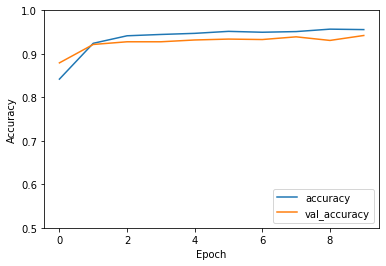

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(LowestHeight, LowestWidth, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3))
model.summary()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
testImagesArray = np.array(testImages)
testLabelsArray = np.array(testLabels)
trainImagesArray = np.array(trainImages)
trainLabelsArray = np.array(trainLabels)
history = model.fit(trainImages, trainLabels, epochs=10, validation_data=(testImages, testLabels))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(testImages,  testLabels, verbose=2)
print("test accuracy: ", test_acc)
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [26]:
predict = model.predict(testImages)
for i in range(10):
    print("Prediction: ", predict[i])
    cv2.imshow("photo", cropImages[testLocation[i]])
    cv2.waitKey(0)

Prediction:  [ 4.97484    -2.4039853  -0.26410276]
Prediction:  [ 9.470162  -2.1220067 -3.9136062]
Prediction:  [10.647507  -8.107521   1.6164827]
Prediction:  [ 5.674546  -4.296032   1.7190068]
Prediction:  [-0.42972118  5.7798657  -1.8093989 ]
Prediction:  [10.315375  -7.773064   1.2673551]
Prediction:  [ 0.98966    3.340497  -2.1112137]
Prediction:  [ 5.277785  -1.0961843 -2.1510181]
Prediction:  [ 14.20699    -10.508628     0.80406344]
Prediction:  [ 5.7041445  -2.7011755  -0.57809424]
